In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.optimize import curve_fit
from lmfit import Model
import matplotlib.gridspec as gridspec
from cmath import rect
import control
import math
import pylab
pylab.rcParams['figure.figsize'] = 10, 5
from IPython.display import Image
from IPython.core.display import HTML 

In [2]:
def flatten_complex (X_jY):
    real_part = np.real(X_jY)
    imag_part = np.imag(X_jY)
    return np.stack([real_part, imag_part], axis=-1)

def Z_total_flattened (f, f_TE, f_M, R_TE, R_M, R):
    return flatten_complex (Z_total(f, f_TE, f_M, R_TE, R_M, R))
    
def Z_total (f, f_TE, f_M, R_TE, R_M, R):
    return R + np.power(np.power(Z_WCT(f, f_TE, R_TE), -1) + np.power(Z_Wa(f, f_M, R_M), -1), -1)

def Z_Wa (f, f_M, R_M):
    beta = np.array(f)/f_M
    jb_rSqrt = (1j*beta)**(-0.5)
    term_tanh = np.tanh((1j*beta)**(0.5))
    return R_M * np.multiply(jb_rSqrt, np.power(term_tanh, -1)) 
    
def Z_WCT (f, f_TE, R_TE):
    # beta = normalized angular frequency
    beta = np.array(f)/f_TE
    jb_rSqrt = (1j*beta)**(-0.5)
    return R_TE * np.multiply(jb_rSqrt, np.tanh((1j*beta)**(0.5))) 


In [3]:
def bode_cartesian (f, R_ohm, R_TE, C_TE):
    # H = R_ohm + R_TE/(C_TE*R_TE*s+1)
    # H = signal.lti([R_ohm*R_TE*C_TE,R_ohm+R_TE], [C_TE*R_TE, 1])
    num = [R_ohm*R_TE*C_TE, R_ohm+R_TE]
    den = [C_TE*R_TE, 1]
    H = signal.TransferFunction(num, den)
    # returned phase is in deg
    w, mag, phase = signal.bode(H, [2*np.pi*freq for freq in f]) # Hz to rad/s
    mag = [10**(dBmag/20) for dBmag in mag]
    nprect = np.vectorize(rect)
    X_jY = nprect(mag, np.deg2rad(phase))
    real_part = np.real(X_jY)
    imag_part = np.imag(X_jY)
#     REAL_WEIGHT = max(real_part)
#     IMAG_WEIGHT = max(imag_part)
    return np.stack([real_part/max(X), imag_part/max(Y)], axis=-1)

def bode_polar (f, R_ohm, R_TE, C_TE):
    num = [R_ohm*R_TE*C_TE, R_ohm+R_TE]
    den = [C_TE*R_TE, 1]
    H = signal.TransferFunction(num, den)
    w, mag, phase = signal.bode(H, [2*np.pi*freq for freq in f])
    mag = [10**(dBmag/20) for dBmag in mag]
    phase = np.deg2rad(phase)
    return np.stack([mag, phase], axis=-1)

Parse and trim datafile

In [4]:
def parse_data (datfilename, freqLB, freqUB, bias_current=1e-3):

    datapoints = []
    freq = []
    X = []
    Y = []
    R = []
    P = []

    lines = open(datfilename, 'r')

    for line in lines:
        try:
            datapoints.append(line.rstrip())
            f = float(line.split()[5])
            assert (f >= freqLB and f <= freqUB)
            freq.append(f)
            
    #         X.append(float(line.split()[1]))
    #         Y.append(float(line.split()[2]))
            v = float(line.split()[3])
            R.append(v/bias_current)
            P.append(float(line.split()[4]))
            
        except:
            pass
        
    Pmin = min(P)
        
    if len(X)<len(R):
        for magnitude, phase, f in zip(R, P, freq):
            real = magnitude * np.cos(phase*np.pi/180)
            img = magnitude * np.sin(phase*np.pi/180)
            X.append(real)
            Y.append(img)
            if Pmin == phase:
                est_f_TE = f
                
    return np.array(X), np.array(Y), np.array(R), np.array(P), np.array(freq), est_f_TE

In [5]:
X, Y, R, P, freq, est_f_TE = parse_data("Contact2_6.dat", 50, 5e5)

#### Optimizers

’leastsq’: Levenberg-Marquardt (default)

’least_squares’: Least-Squares minimization, using Trust Region Reflective method

’differential_evolution’: differential evolution

’brute’: brute force method

’basinhopping’: basinhopping

’ampgo’: Adaptive Memory Programming for Global Optimization

’nelder’: Nelder-Mead

’lbfgsb’: L-BFGS-B

’powell’: Powell

’cg’: Conjugate-Gradient

’newton’: Newton-CG

’cobyla’: Cobyla

’bfgs’: BFGS

’tnc’: Truncated Newton

’trust-ncg’: Newton-CG trust-region

’trust-exact’: nearly exact trust-region

’trust-krylov’: Newton GLTR trust-region

’trust-constr’: trust-region for constrained optimization

’dogleg’: Dog-leg trust-region

’slsqp’: Sequential Linear Squares Programming

’emcee’: Maximum likelihood via Monte-Carlo Markov Chain

’shgo’: Simplicial Homology Global Optimization

’dual_annealing’: Dual Annealing optimization

In [25]:
def fit_data(X, Y, confidence = 1.5, minimizer = "leastsq", reffunc = Z_total_flattened):
        
        # initial guess
        est_R = 23.1
        est_R_TE = 0.9
        est_f_M = 1400
        est_R_M = 0.62
        est_f_TE= 1331

        # pass 1d array to avoid complex part being trimmed by scipy
        X_jY = np.zeros_like(X, dtype=np.complex)
        X_jY = np.array([x+1j*y for (x, y) in zip(X,Y)])
        X_jY_flattened = np.stack([np.real(X_jY), np.imag(X_jY )], axis=-1)
        
        bode_model = Model(reffunc)
        
        bode_model.set_param_hint('R', value=est_R, min=est_R/confidence,max=est_R*confidence)
        bode_model.set_param_hint('f_TE', value=est_f_TE, min=est_f_TE/confidence,max=est_f_TE*confidence)
        bode_model.set_param_hint('R_TE', value=est_R_TE, min=est_R_TE/confidence,max=est_R_TE*confidence)
        bode_model.set_param_hint('f_M', value=est_f_M, min=est_f_M/confidence,max=est_f_M*confidence)
        bode_model.set_param_hint('R_M', value=est_R_M, min=est_R_M/confidence,max=est_R_M*confidence)
        
        params = bode_model.make_params(R = est_R, R_TE=est_R_TE, f_TE=est_f_TE, R_M=est_R_M, f_M=est_f_M)
        
        print('---------------------------REPORT-----------------------------')
        print("[[Confidence]] = {}\n[[Minimizer]] = {}\n[[ReferenceFunction]] = {}"\
              .format(confidence, minimizer, reffunc.__name__))
        print('[[zT initialguess]] = R_TE/R_ohm = '+str((est_R_TE)/est_R))
        
        Z_fit_obj = bode_model.fit(X_jY_flattened, params, f=freq, method=minimizer) #

        
        initial_fit = Z_fit_obj.init_fit
        nprect = np.vectorize(rect)
        initial_fit = initial_fit[:, 0]*max(X) + 1j*initial_fit[:, 1]*max(Y)
            
        Z_fit = Z_fit_obj.best_fit    
        Z_fit = Z_fit[:, 0]*max(X) + 1j*Z_fit[:, 1]*max(Y)
        print(Z_fit_obj.fit_report())
        
        
        est_R = Z_fit_obj.params['R'].value
        est_R_TE = Z_fit_obj.params['R_TE'].value
        est_R_M = Z_fit_obj.params['R_M'].value
        est_f_M = Z_fit_obj.params['f_M'].value
        est_f_TE= Z_fit_obj.params['f_TE'].value
        
        print('[[Predictions]]')
        print('zT = R_TE/R_ohm = '+str(est_R_TE/est_R))
        print('R = {}'.format(est_R))
        print('R_M = {}'.format(est_R_M))
        print('R_TE = {}'.format(est_R_TE))
        print('f_TE = {}'.format(est_f_TE))
        print('f_M = {}'.format(est_f_M))
        print('f lim -> 0 dashed line = est_R_ohm+est_R_TE = '+str((est_R+est_R_TE)))
        print('f lim -> inf dashed line = est_R_ohm = '+str(est_R))
        
        return Z_fit, initial_fit, est_R, est_R_TE, est_R_M, est_f_M, est_f_TE
        


In [26]:
Z_fit, initial_fit, est_R, est_R_TE, est_R_M, est_f_M, est_f_TE = fit_data(X, Y)#, minimizer = "emcee"
bool_curvefit = True

---------------------------REPORT-----------------------------
[[Confidence]] = 1.5
[[Minimizer]] = leastsq
[[ReferenceFunction]] = Z_total_flattened
[[zT initialguess]] = R_TE/R_ohm = 0.03896103896103896
[[Model]]
    Model(Z_total_flattened)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 153
    # data points      = 2640
    # variables        = 5
    chi-square         = 1.91901811
    reduced chi-square = 7.2828e-04
    Akaike info crit   = -19068.5422
    Bayesian info crit = -19039.1496
[[Variables]]
    f_TE:  1996.49997 +/- 377.951773 (18.93%) (init = 1331)
    f_M:   2071.25075 +/- 109.543913 (5.29%) (init = 1400)
    R_TE:  0.91452914 +/- 0.00215612 (0.24%) (init = 0.9)
    R_M:   0.93000000 +/- 0.10522533 (11.31%) (init = 0.62)
    R:     22.6786256 +/- 0.00178109 (0.01%) (init = 23.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(f_TE, R_M)  = -0.981
    C(f_M, R_M)   = -0.972
    C(f_TE, f_M)  =  0.914
    C(R_TE, R)    = -0.802

R_M = 2S^2 T_i * L_M / lambda_M / A

f_M = alpha_M/L_M^2 / 2 / np.pi

In [27]:
TLapprox = est_R + Z_WCT(freq, est_f_TE, est_R_TE)

TLapprox2 = Z_total(freq, est_f_TE, est_f_M, est_R_TE, est_R_M, est_R)

R_ohm = 22.67862555584577
R_TE = 0.9145291388897324


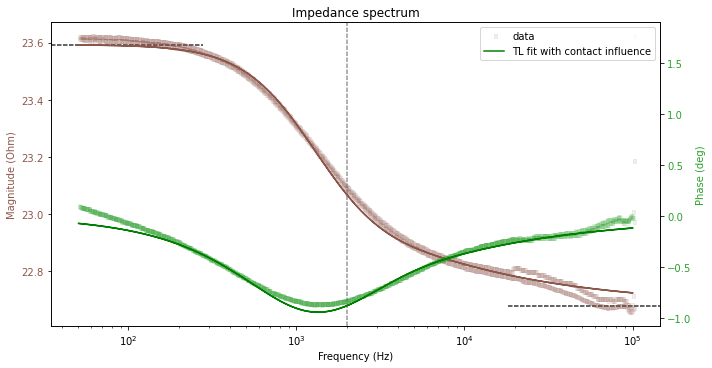

In [28]:
fig, ax1 = plt.subplots(1)
ax2 = ax1.twinx()
ax1.set_xlabel('Frequency (Hz)')
plt.xscale('log')
color = 'tab:brown'
ax1.set_ylabel('Magnitude (Ohm)', color=color)

ax1.axhline(y=est_R, dashes=[3, 1], color='0.2', xmin=0.75, xmax=1)
ax1.axhline(y=est_R+est_R_TE, dashes=[3, 1], color='0.2', xmin=0, xmax=0.25)
ax1.axvline(x=est_f_TE, dashes=[3, 1], color='0.6')
ax1.plot(freq, R, marker='$.$', color=color, alpha=0.1, linestyle='None', label='data')
ax1.plot(freq, np.abs(TLapprox2), color=color, label='TL fit with contact influence')

ax1.tick_params(axis='y', labelcolor=color)
    
color = 'tab:green'
ax2.set_ylabel('Phase (deg)', color=color)
        
ax2.plot(freq, P, marker='$.$', color=color, alpha=0.1, linestyle='None', label='data')
ax2.plot(freq, np.angle(TLapprox2, deg=True), color="g", label='TL fit with contact influence')

ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()
plt.legend(loc="upper right")
plt.title('Impedance spectrum')
print('R_ohm = {}'.format(est_R))
print('R_TE = {}'.format(est_R_TE))

Text(0.5, 1.0, 'Impedance spectrum')

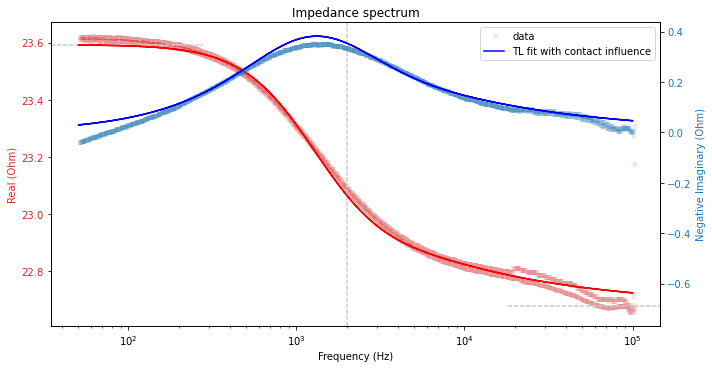

In [29]:
fig, ax3 = plt.subplots(1)
ax4 = ax3.twinx()
ax3.set_xlabel('Frequency (Hz)')
plt.xscale('log')

color = 'tab:red'
ax3.plot(freq, X, marker='$.$', color=color, alpha=0.1, linestyle='None', label='data')
ax3.set_ylabel('Real (Ohm)', color=color)
ax3.tick_params(axis='y', labelcolor=color)

ax3.axvline(x=est_f_TE, dashes=[3, 1], color='0.8')
ax3.axhline(y=est_R, dashes=[3, 1], color='0.8', xmin=0.75, xmax=1)
ax3.axhline(y=est_R+est_R_TE, dashes=[3, 1], color='0.8', xmin=0, xmax=0.25)
# ax3.plot(freq, np.real(TLapprox), dashes=[3, 3], color=color, alpha=0.5, label='constant temperature')
ax3.plot(freq, np.real(TLapprox2), color="r", label='with contact influence')
    
ax4.tick_params(axis='y')
color = 'tab:blue'
ax4.plot(freq, (-1)*Y, marker='$.$', color=color, alpha=0.1, linestyle='None', label='data')
# ax4.plot(freq, (-1)*np.imag(TLapprox), dashes=[3, 3], color=color, alpha=0.5, label='TL fit constant temperature')
ax4.plot(freq, (-1)*np.imag(TLapprox2), color="b", label='TL fit with contact influence')


ax4.set_ylabel('Negative Imaginary (Ohm)', color=color)
ax4.tick_params(axis='y', labelcolor=color)
plt.legend(loc="best")
fig.tight_layout()
plt.title('Impedance spectrum')

Nyquist reference: a circle with diameter R_TE, centred at position ( R_0+R_TE/2, 0 )

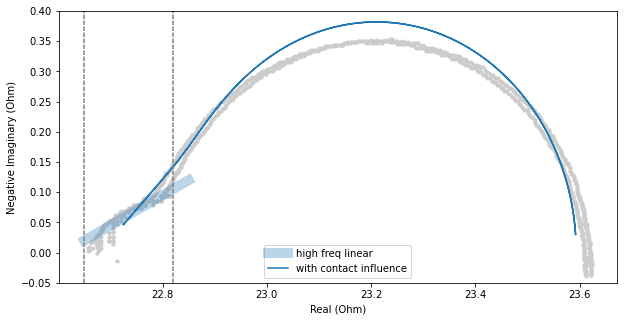

In [44]:
X_highfreqlim = np.linspace(22.65, 22.85, 100)
minY_highfreqlim = np.linspace(0, 0.1, 100)+0.02
theta = np.linspace(0, np.pi, 100)
r = est_R_TE/2

X_ref = r*np.cos(theta)+(est_R+est_R_TE/2)
Y_ref = r*np.sin(theta)

fig, axNyquist = plt.subplots(1)
plt.scatter(X, -1*Y, marker=".", color="0.8")
axNyquist.plot(X_highfreqlim, minY_highfreqlim, color=color, alpha = 0.3, linewidth=10, label='high freq linear')
# axNyquist.plot(np.real(TLapprox), -np.imag(TLapprox), color="r", label='without contact influence')
axNyquist.plot(np.real(TLapprox2), -np.imag(TLapprox2), color=color, label='with contact influence')
axNyquist.axvline(x=22.65, dashes=[3, 1], color='0.5')
axNyquist.axvline(x=22.82, dashes=[3, 1], color='0.5')
plt.legend()
plt.ylim ([ -0.05, 0.4 ])
axNyquist.set_ylabel('Negative Imaginary (Ohm)')
axNyquist.set_xlabel('Real (Ohm)')
plt.show()


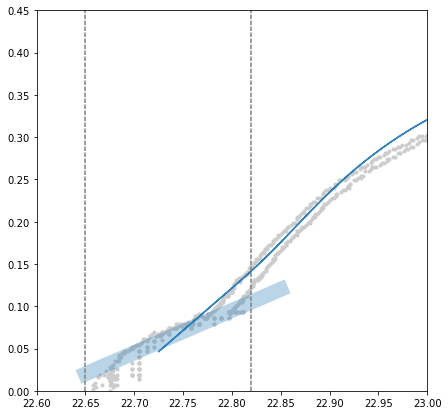

In [40]:
fig, axNyquist = plt.subplots(1, figsize=(7, 7))
plt.scatter(X-22.8, -1*Y, marker=".", color="0.8")
plt.scatter(X, -1*Y, marker=".", color="0.8")
axNyquist.plot(X_highfreqlim, minY_highfreqlim, color=color, alpha = 0.3, linewidth=15, label='high freq linear slope = 1')
axNyquist.plot(np.real(TLapprox2), -np.imag(TLapprox2), alpha = 0.9, color=color, label='with contact influence')
axNyquist.axvline(x=22.65, dashes=[3, 1], color='0.5')
axNyquist.axvline(x=22.82, dashes=[3, 1], color='0.5')
plt.ylim ([ 0, 0.45 ])
plt.xlim ([22.6, 23])
plt.show()